In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from scipy.optimize import minimize
import math



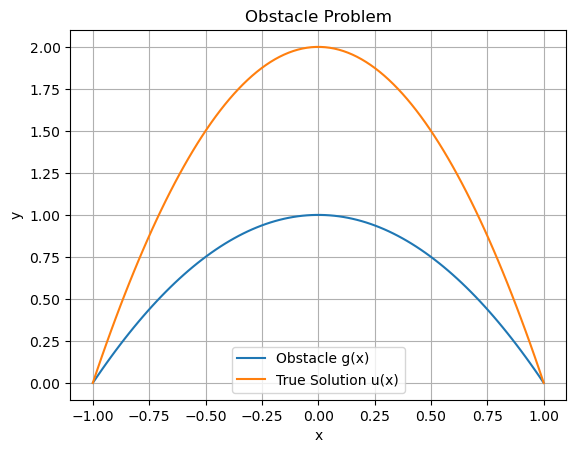

In [2]:
# Define the domain
x = np.linspace(-1, 1, 100)

# Define the obstacle function
g = -x**2 + 1

# Define the true solution
true_solution = -2 * x**2 + 2

# Define the right-hand side function
f = 4

# Plotting the obstacle function, true solution, and computed solution
plt.plot(x, g, label='Obstacle g(x)')
plt.plot(x, true_solution, label='True Solution u(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Obstacle Problem')
plt.legend()
plt.grid(True)
plt.show()

Epoch 0/2000, Loss: 11363.279296875


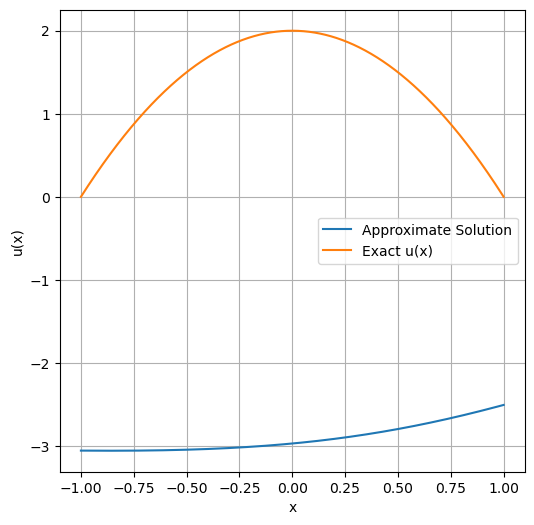

Epoch 100/2000, Loss: 23.349895477294922


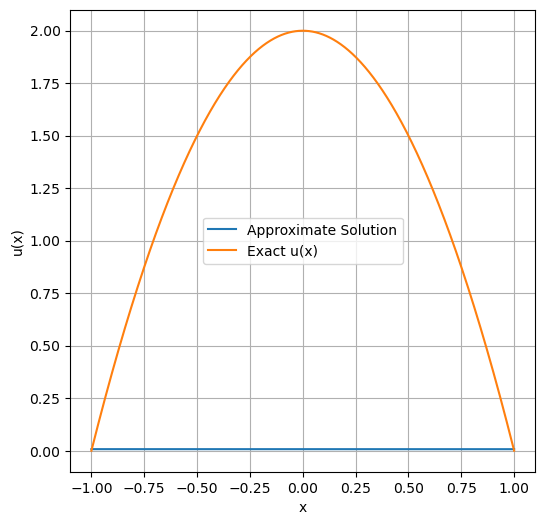

Epoch 200/2000, Loss: 23.526657104492188


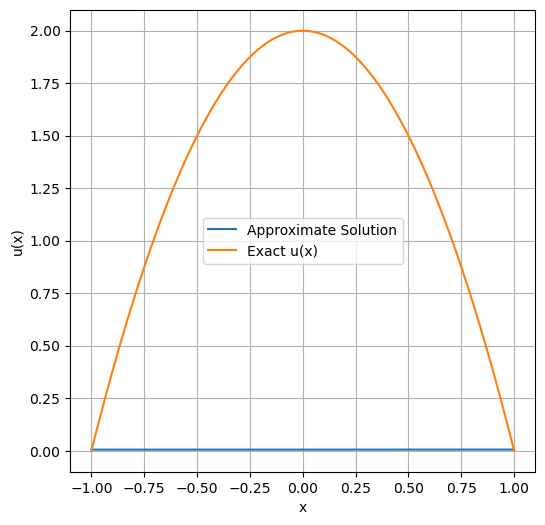

Epoch 300/2000, Loss: 24.445960998535156


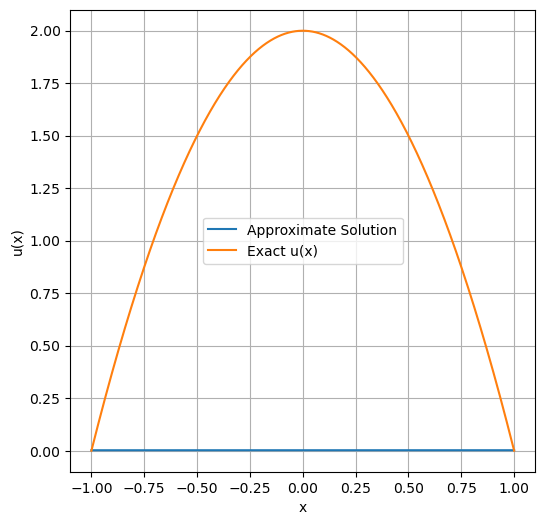

Epoch 400/2000, Loss: 25.87653350830078


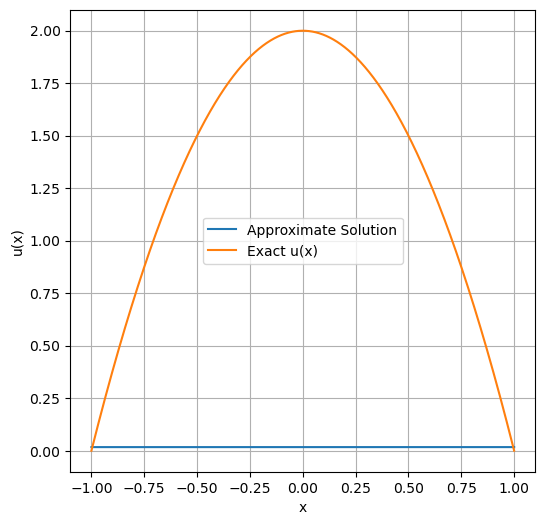

Epoch 500/2000, Loss: 21.123327255249023


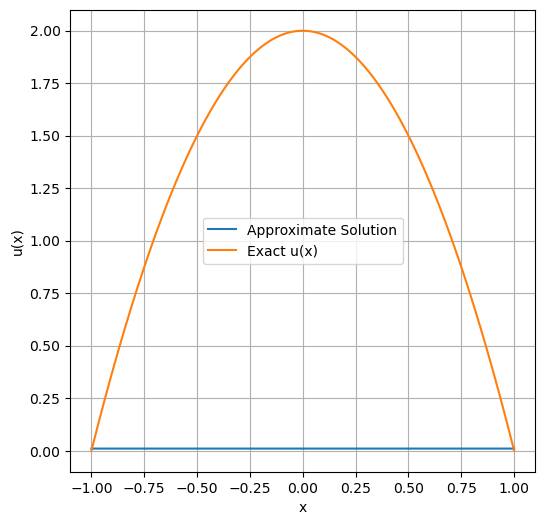

Epoch 600/2000, Loss: 21.758115768432617


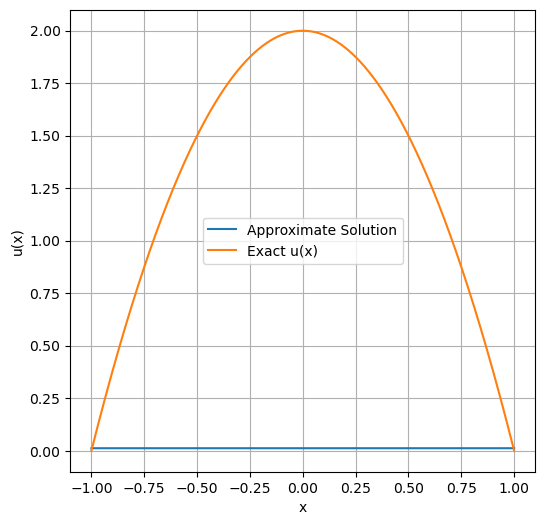

Epoch 700/2000, Loss: 24.27777862548828


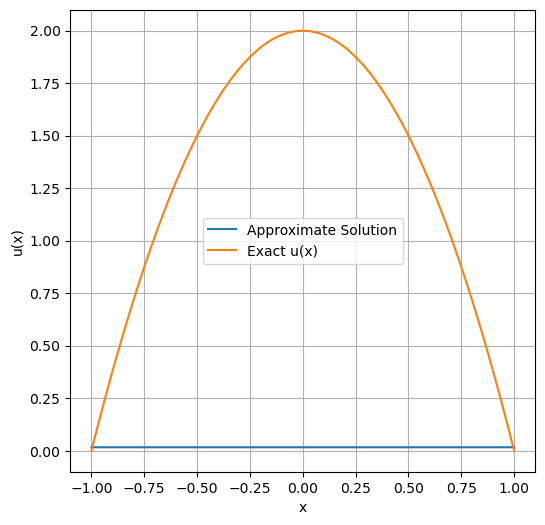

Epoch 800/2000, Loss: 98.04855346679688


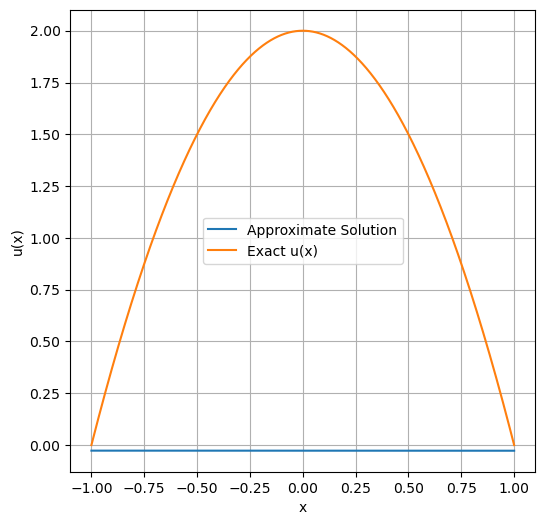

Epoch 900/2000, Loss: 20.6763858795166


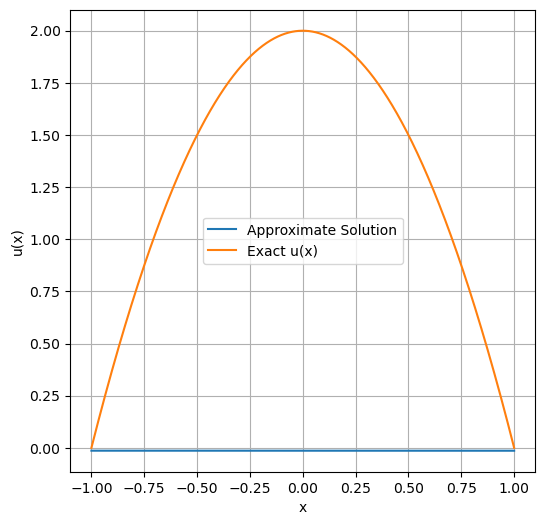

Epoch 1000/2000, Loss: 30.61089515686035


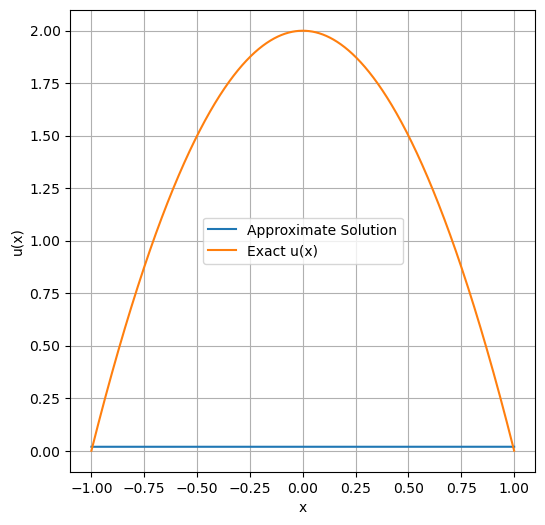

Epoch 1100/2000, Loss: 22.8761043548584


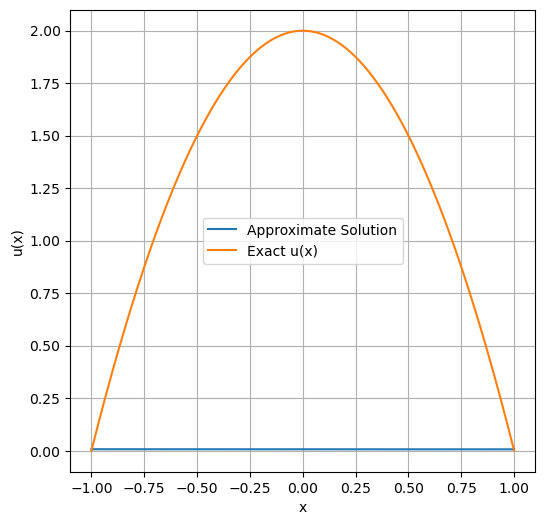

Epoch 1200/2000, Loss: 18.983535766601562


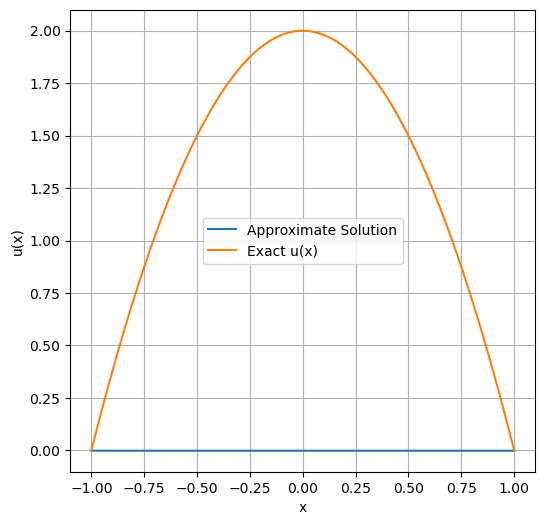

KeyboardInterrupt: 

In [3]:
class PINN(nn.Module):
    def __init__(self,num_layers = 5, hidden_size = 60, output_size = 1, input_size = 1):
        
        super().__init__()
        h = hidden_size
        assert num_layers >=2
        self.fc_u = nn.ModuleList()
        self.ln_u = nn.ModuleList()
        self.fc_lambda = nn.ModuleList()
        self.ln_lambda = nn.ModuleList()
        self.fc_u.append(nn.Linear(input_size, h))
        self.ln_u.append(nn.LayerNorm(h))
        for _ in range(num_layers - 2):
            self.fc_u.append(nn.Linear(h, h))
            self.ln_u.append(nn.LayerNorm(h))
        self.fc_u.append(nn.Linear(h, output_size))
        self.fc_lambda.append(nn.Linear(input_size, h))
        self.ln_lambda.append(nn.LayerNorm(h))
        
        
        for _ in range(num_layers - 2):
            self.fc_lambda.append(nn.Linear(h, h))
            self.ln_lambda.append(nn.LayerNorm(h))
        self.fc_lambda.append(nn.Linear(h, output_size))
        
#         self.fc_lambda.apply(lambda_weights_init)
#         self.fc_u.apply(u_weights_init)

    def forward(self, x):
        u = self.u_net(x)
        lambda_val = self.lambda_net(x)
        return u, lambda_val

    def u_net(self, x):
        for i in range(len(self.fc_u) - 1):
            layer = self.fc_u[i]
#             layernorm = self.ln_u[i]
            x = layer(x)
#             x = layernorm(x)
        x = self.fc_u[-1](x)
        return x

    def lambda_net(self, x):
        for i in range(len(self.fc_lambda) - 1):
            layer = self.fc_lambda[i]
#             layernorm = self.ln_lambda[i]
            x = layer(x)
#             x = layernorm(x)
            
        x = self.fc_lambda[-1](x)
#         x = -torch.exp(x)
        return x
    
# def lambda_weights_init(m):
#     if isinstance(m, nn.Linear):
#         torch.nn.init.normal_(m.weight, mean=-1 , std=0.4)  # Initialize weights with a normal distribution centered at -0.5
#         m.bias.data.fill_(0.01)
        
# def u_weights_init(m):
#     if isinstance(m, nn.Linear):
#         torch.nn.init.normal_(m.weight, mean=2, std=1)  # Initialize weights with a normal distribution centered at -0.5
#         m.bias.data.fill_(0.01)

def cal_u_exact(x):
    u = -2 * x**2 + 2
    return u
        
def g(x):
    out = -x**2 + 1
    return out


            
def loss_function(u, x, g, lambda_val, gamma):
    u_prime = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_doubleprime = torch.autograd.grad(u_prime, x, grad_outputs=torch.ones_like(u_prime), create_graph=True, retain_graph=True)[0]
    
#     loss = (10**(-3)) * torch.sum(torch.square(torch.min((- u_doubleprime + lambda_val), torch.zeros_like(- u_doubleprime - lambda_val))))
    
#     loss = torch.sum(torch.square(torch.min(-u_doubleprime, torch.zeros_like(u_doubleprime)) + (1/gamma) * torch.max(torch.zeros_like(u), g - gamma * lambda_val - u))) # -u'' + lambda = 0
    loss = torch.sum(torch.square(torch.min(u_doubleprime) + lambda_val))
    
    #loss += torch.sum(torch.square(u_doubleprime + lambda_val) * (u - g))
    
#     obstacle_term = (torch.min((u - g), torch.zeros_like(u - g))) # (u - g) >= 0
#     loss += torch.sum(torch.square(obstacle_term)) 
    
    #loss += torch.sum(torch.square(torch.max(lambda_val, torch.zeros_like(lambda_val))))  # lambda <= 0
    
    #loss += torch.sum(torch.square((g - u) * lambda_val))  # (g - u) * lambda = 0
                     
    loss += torch.sum(torch.square(lambda_val + (1/gamma) * torch.max(torch.zeros_like(u), g - gamma * lambda_val - u))) 
    loss += (10**(4)) * torch.sum(torch.square(u[0]))
    loss += (10**(4)) * torch.sum(torch.square(u[-1]))    

    return loss

def train(model, x, g, gamma, epochs=2000, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        u, lambda_val = model(x)
        
        energy = loss_function(u, x, g, lambda_val, gamma)
        loss = energy 
        loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if epoch % 100 == 0:
            
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")
            x_np = x.detach().numpy()
            u_np = model.u_net(x).detach().numpy()
            u_exact_np = cal_u_exact(x).detach().numpy()
            lambda_np = model.lambda_net(x).detach().numpy()

            plt.figure(figsize=(6, 6))
            plt.plot(x_np, u_np, label='Approximate Solution')
            plt.plot(x_np, u_exact_np, label='Exact u(x)')
#             plt.plot(x_np, g.detach().numpy(), label='Obstacle g(x)')
#             plt.plot(x_np, lambda_np, label='Lambda Function')
            plt.xlabel('x')
            plt.ylabel('u(x)')
#             plt.title('Approximate Solution; '+f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")
            plt.grid(True)
            plt.legend()
            plt.show()
            
#         if loss < 3000:
#             break


x = torch.linspace(-1, 1, 2000).reshape(-1, 1)
x.requires_grad_(True)

gx = g(x)  # obstacle function
gamma = 7.5

model = PINN()



train(model, x, gx, gamma)


In [ ]:
u_approx = model.u_net(x)

x_np = x.detach().numpy()
u_approx_np = u_approx.detach().numpy()
lambda_np = model.lambda_net(x).detach().numpy()

u_exact_np = cal_u_exact(x).detach().numpy()
plt.plot(x_np, u_exact_np, label='Exact u(x)')
# plt.plot(x_np, gx.detach().numpy(), label='Obstacle g(x)')
plt.plot(x_np, u_approx_np, label='Approximate Solution')
plt.plot(x_np, lambda_np, label='Lambda Function')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
l2_norm = np.linalg.norm(u_exact_np - u_approx_np)
l2_norm

In [ ]:
relative_error = np.linalg.norm(u_exact_np - u_approx_np) / np.linalg.norm(u_exact_np)

accurate_percentage = (1 - relative_error) * 100

print(f"The model accurately captures {accurate_percentage:.2f}% of u_exact_np.")